In [1]:
### FIX LINK FOR FUNCTIONS WHEN PUSH TO MASTER ###

In [2]:
import sys
import re
import json
import pandas as pd
import numpy as np
from datetime import datetime

from trump import load, treat, text

from gensim.models.word2vec import Word2Vec 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

plots_args = {'fontsize': 14, 'color': '#9370DB'}
FIGURE_FOLDER = '../history/figures/'

In [3]:
df = load.load_tweets()

check function [load_tweets](https://github.com/liabifano/project/blob/master/trump/src/trump/load.py#L16)

In [4]:
df['clean_tokens'], df['clean_text'] = text.clean_series(df['text'])

check function [clean_series](https://github.com/liabifano/project/blob/master/trump/src/trump/text.py)

# Writing Style

In [5]:
### TODO: DESCRIBE ###

### Over time

In [30]:
def plot_interval_by_cohort(df, cohort, metric, color):
    agg = (df
           .sort_values('first_day_month_cohort')
           .groupby(cohort)
           .describe()[metric])
    
    agg['lower_bound'] = agg['mean'] - 2*agg['std'] / np.sqrt(agg['count'])
    agg['upper_bound'] = agg['mean'] + 2*agg['std'] / np.sqrt(agg['count'])
    
    agg['lower_bound'].plot(linestyle=':', color=c, alpha=0.7, legend=False, label='_nolegend_');
    agg['upper_bound'].plot(linestyle=':', color=c, alpha=0.7, legend=False, label='_nolegend_');
    agg['mean'].plot(linestyle='-', linewidth=3, fontsize=20, color=c, legend=True);
    
    plt.title('Writing style by Quarter'.format(metric), fontsize=20); 
    plt.xlabel('Time', fontsize=20); plt.ylabel('Mean', fontsize=20);

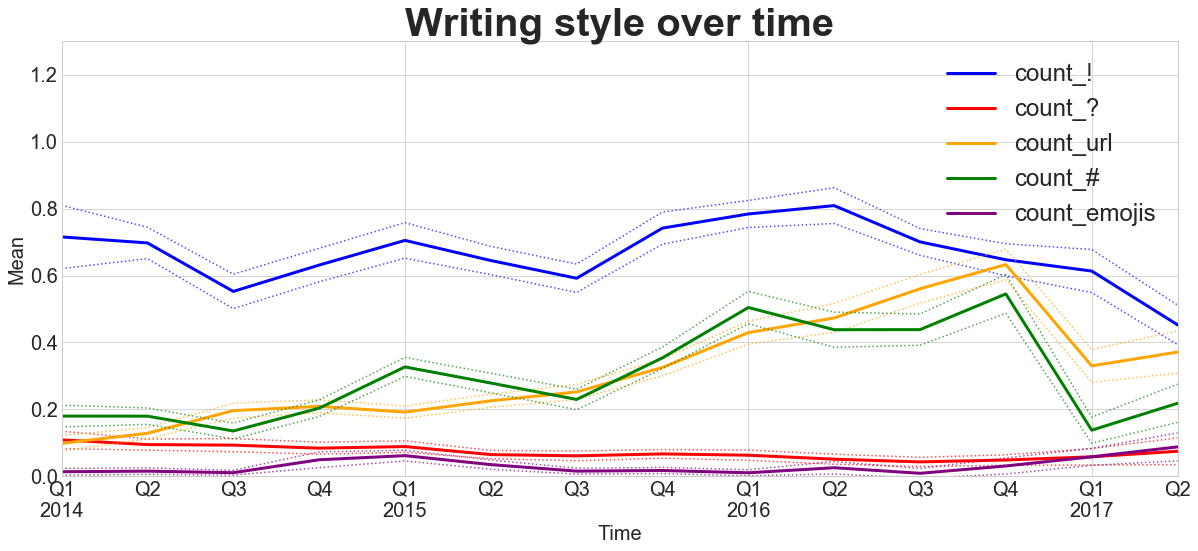

In [35]:
metric_writing_style = [('count_!', 'blue'),
                        ('count_?', 'red'), 
                        ('count_url', 'orange'),
                        ('count_#', 'green'),
                        ('count_emojis', 'purple')]

filtered = df[(df['first_day_month_cohort'] > datetime(2014,1,1)) & 
              (df['first_day_month_cohort'] < datetime(2017, 5, 30))]

plt.figure(figsize=(20,8))
for m, c in metric_writing_style:
    plot_interval_by_cohort(filtered, 'quarter_cohort', m, c)
    plt.ylim([0, 1.3])
    plt.plot()
plt.legend(list(map(lambda x: x[0], metric_writing_style)), loc=1, fontsize=24);
plt.title('Writing style over time', fontsize=40, fontweight='bold'); 
plt.savefig(FIGURE_FOLDER + 'writing_style_over_time.png')

In [8]:
### TODO: COMMENT ###

In [36]:
tags = text.count_tags(df['clean_tokens'])
df = pd.concat([df, tags], axis=1)

check [count_tags]()

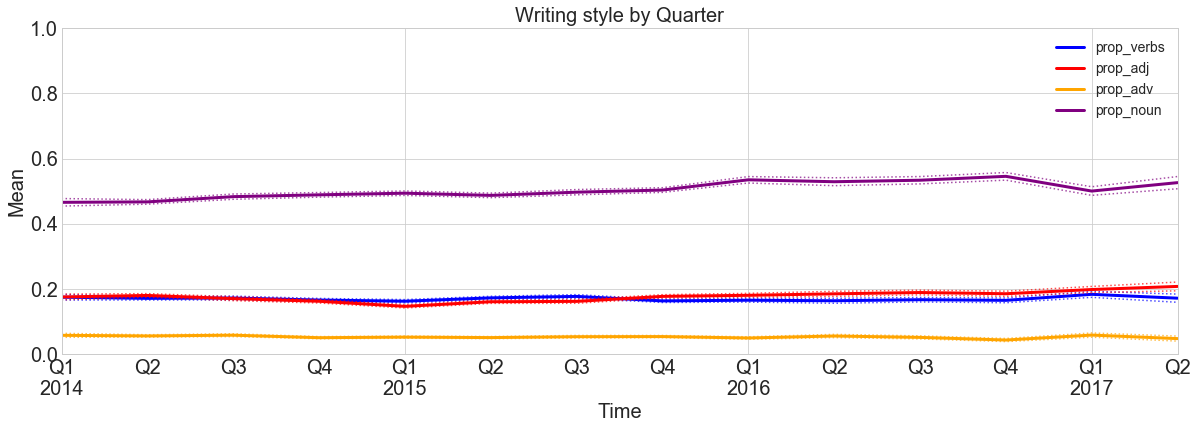

In [37]:
tags_writing_style = [('prop_verbs', 'blue'), 
                      ('prop_adj', 'red'),
                      ('prop_adv', 'orange'), 
                      ('prop_noun', 'purple')]

filtered = df[(df['first_day_month_cohort'] > datetime(2014,1,1)) & 
              (df['first_day_month_cohort'] < datetime(2017, 5, 30))]

plt.figure(figsize=(20,6))
for m, c in tags_writing_style:
    plot_interval_by_cohort(filtered, 'quarter_cohort', m, c)
    plt.ylim([0, 1])
    plt.plot()
plt.legend(list(map(lambda x: x[0], tags_writing_style)), loc=1, fontsize=14);

In [11]:
### TODO: COMMENT ###

### by subject

In [12]:
df = text.get_hardcoded_subjects(df)
subjects = ['hillary', 'obama', 'make_america', 'war', 'democra']

Number of tweets with hillary: 987 (3.2 %)


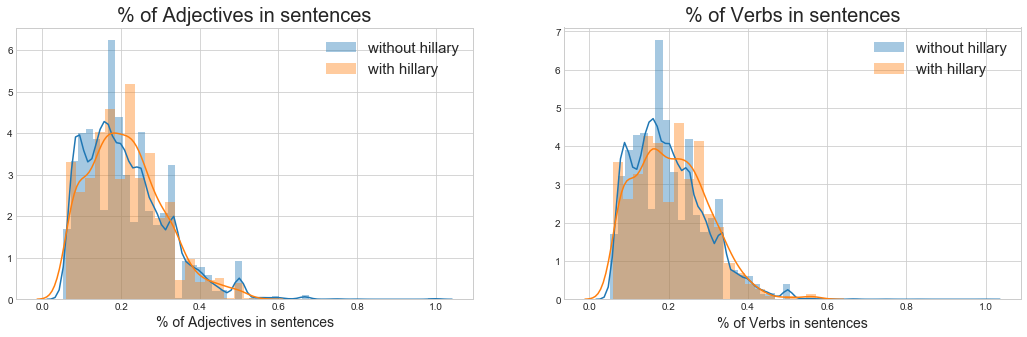

Number of tweets with obama: 2540 (8.1 %)


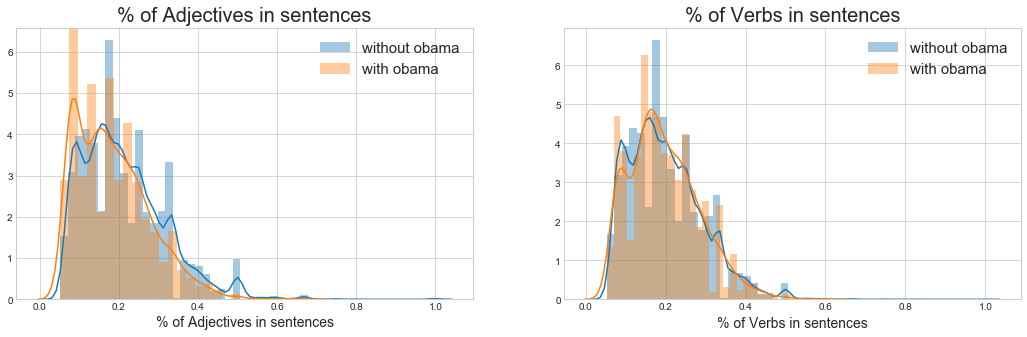

Number of tweets with make_america: 1070 (3.4 %)


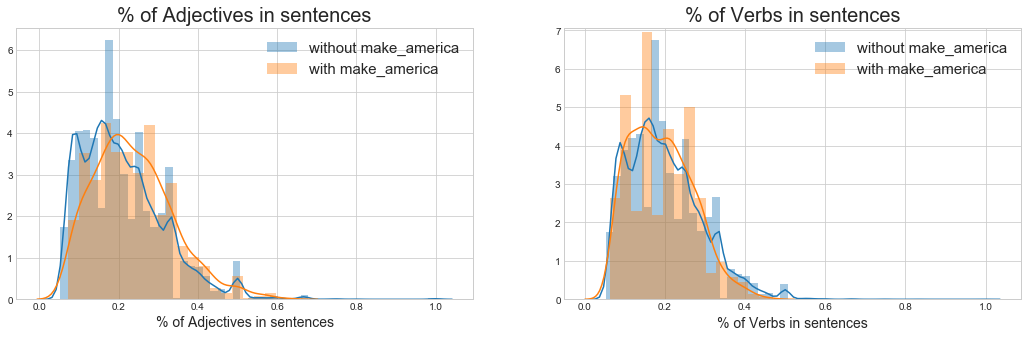

Number of tweets with war: 1165 (3.7 %)


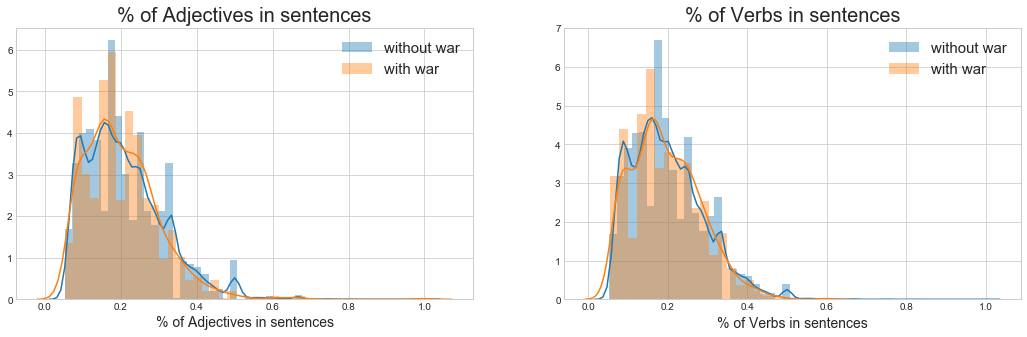

Number of tweets with democra: 218 (0.7 %)


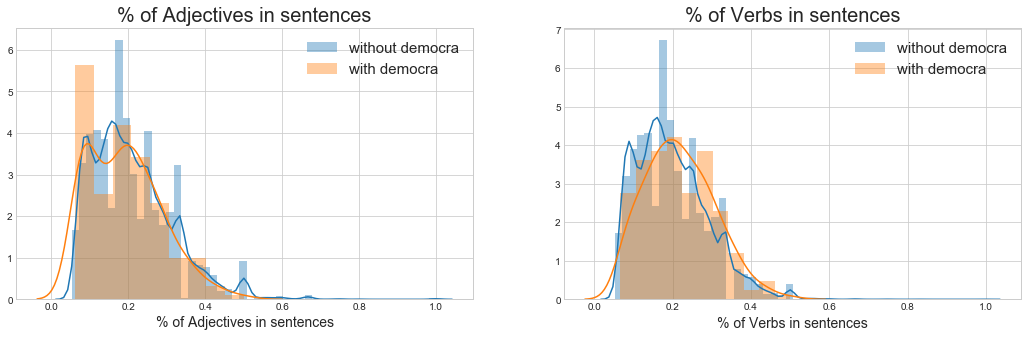

In [13]:
for sub in subjects:
    print('Number of tweets with {}: {} ({} %)'
          .format(sub, df[sub].sum(), 
                  round(100*df[sub].sum()/len(df), 1)))

    fig, ax = plt.subplots(1, 2, figsize=(18, 5))
    filtered = df[df['prop_adj'] > 0]
    sns.distplot(filtered.loc[~filtered[sub]]['prop_adj'], ax=ax[0]);
    sns.distplot(filtered.loc[filtered[sub]]['prop_adj'], ax=ax[0]);
    ax[0].legend(['without {}'.format(sub), 'with {}'.format(sub)], loc='best', fontsize=15);
    ax[0].set_title('% of Adjectives in sentences', fontsize=20);
    ax[0].set_xlabel("% of Adjectives in sentences", fontsize=14)
    ax[0].set_title('% of Adjectives in sentences', fontsize=20);

    filtered = df[df['prop_verbs'] > 0]
    sns.distplot(filtered.loc[~filtered[sub]]['prop_verbs'], ax=ax[1]);
    sns.distplot(filtered.loc[filtered[sub]]['prop_verbs'], ax=ax[1]);
    ax[1].legend(['without {}'.format(sub), 'with {}'.format(sub)], loc='best', fontsize=15);
    ax[1].set_xlabel("% of Verbs in sentences", fontsize=14)
    ax[1].set_title('% of Verbs in sentences', fontsize=20);
    
    plt.show()

In [14]:
### TODO: COMMENT ###

### by Device

In [15]:
### TODO: DESCRIBE ###

Out-of-bag score: 69.8%


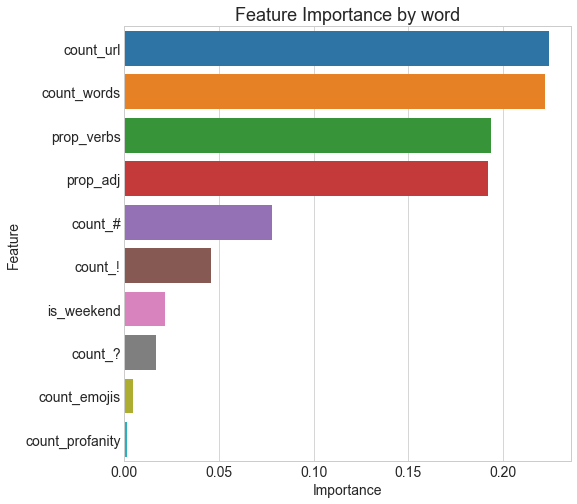

In [38]:
from sklearn.ensemble import RandomForestClassifier

valid_devices = ['Twitter for iPhone', 'Twitter Web Client', 'Twitter for Android']
features = ['is_weekend', 'count_url','count_!', 'count_?', 'count_#', 
            'count_words', 'count_emojis', 'count_profanity', 'prop_adj', 
            'prop_verbs']
df_channels = df[(df['source'].apply(lambda x: x in valid_devices)) & 
                 (df['first_day_month_cohort'] > datetime(2016,1,1)) & 
                 (df['first_day_month_cohort'] < datetime(2017, 5, 30))]

def plot_importance_rf(df, features, label):
    clf = RandomForestClassifier(n_estimators=100, 
                                 random_state=189, 
                                 oob_score=True)
    clf.fit(df[features], df[label]);

    importances = clf.feature_importances_
    feat_importance = (pd.DataFrame(list(zip(features, importances)), 
                               columns=['feature', 'importance'])
                  .sort_values('importance', ascending=False))
    f, ax = plt.subplots(figsize=(8, 8))
    ax = sns.barplot(y='feature', x='importance', 
                     data=feat_importance,
                     saturation=0.8)
    ax.set_title('Feature Importance by word', fontsize=18)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)
    plt.xlabel('Importance', fontsize=14); plt.ylabel('Feature', fontsize=14);
    print('Out-of-bag score: {s}%'.format(s=100*round(clf.oob_score_, 3)));
    ax;
    
plot_importance_rf(df_channels, features, 'source')

In [17]:
### TODO: COMMENT ###

In [70]:
df_channels['source'].unique()

array(['Twitter for iPhone', 'Twitter for Android', 'Twitter Web Client'], dtype=object)

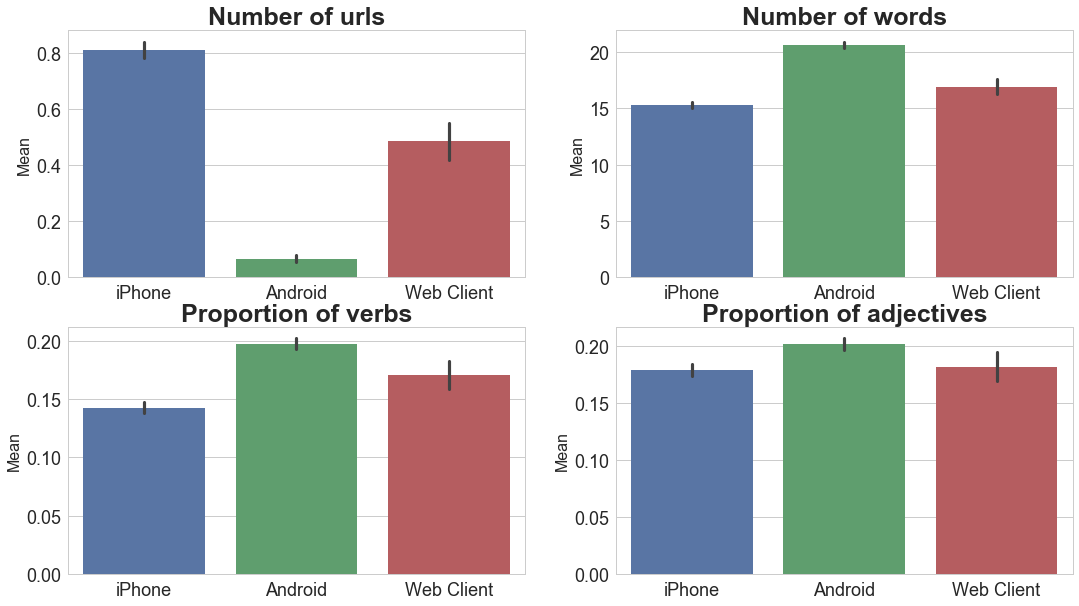

In [71]:
relevant_features = ['count_url', 'count_words', 'prop_verbs', 'prop_adj']
sns.set(font_scale=1.8)
sns.set_style("whitegrid")
nice_lookup = {
    'count_url': 'Number of urls',
    'count_words': 'Number of words',
    'prop_verbs': 'Proportion of verbs',
    'prop_adj': 'Proportion of adjectives'
}
nice_sources = {
    'Twitter for iPhone': 'iPhone',
    'Twitter for Android': 'Android',
    'Twitter Web Client': 'Web Client'
}

df_channels['nice_source'] = df_channels['source'].apply(lambda x: nice_sources[x])
f, ax = plt.subplots(2, 2, figsize=(18, 10))
positions = np.array(range(4)).reshape(2, 2)

for i, feat in enumerate(relevant_features): 
    pos = np.where(positions==i)
    sns.barplot(x='nice_source', y=feat, data=df_channels, ax=ax[pos[0][0], pos[1][0]])
    ax[pos[0][0], pos[1][0]].set_title(nice_lookup[feat], fontweight='bold', fontsize=25)
    ax[pos[0][0], pos[1][0]].set_xlabel('')
    ax[pos[0][0], pos[1][0]].set_ylabel('Mean', fontsize=16)
plt.savefig(FIGURE_FOLDER + 'writing_style_by_device.png')

In [19]:
### TODO: COMMENT ###

## Word2Vec

In [20]:
### TODO: DESCRIBE ###

In [21]:
tweet_w2v = Word2Vec(size=100, min_count=1)
tweet_w2v.build_vocab([x for x in list(list(df['clean_tokens']))])
tweet_w2v.train([x for x in list(df['clean_tokens'])], 
                epochs=tweet_w2v.iter,
                total_examples=tweet_w2v.corpus_count)
word_vectors = tweet_w2v.wv
print('Number of words: {}'.format(len(word_vectors.vocab)))

Number of words: 43258


In [22]:
context_words = ['america', 'democrats', 'republicans',
                 'hillary', 'obama', 
                 'war', 
                 'russia', 'china', 'iran', 'syria', 'brazil', 'mexico',
                 'cnn', 'fake', 'crooked']

contexts = pd.DataFrame()
for w in context_words:
    context = pd.DataFrame([x[0] for x in word_vectors.most_similar(w)], columns=[w])
    contexts = pd.concat([contexts, context], axis=1)
contexts

,america,democrats,republicans,hillary,obama,war,russia,china,iran,syria,brazil,mexico,cnn,fake,crooked
0,collapsing,americans,stop,hilary,unfit,guns,fact,republicans,trade,politicians,supreme,vets,watching,stock,beat
1,america…,stop,democrats,beat,boehner,crime,mitt,stop,u.s.,actually,supporters,chinese,hours,daily,clinton
2,principals,dont,americans,crooked,choked,expect,destroy,steal,republicans,somebody,expert,enemy,morning_joe,often,bernie
3,together,candidate,syria,choked,pandering,takes,isis,wants,seems,seems,part,risk,network,learned,judgement
4,country,nothing,incompetent,even,opposes,lies,lose,must,incompetent,pay,hopefully,control,geraldorivera,judge,bush
5,safe,republicans,wants,boehner,hilary,send,wrong,russia,problems,destroy,simple,social,clock,court,jeb
6,founding,thought,iran,judgement,treasury,advantage,beaten,robbing,iraq,understand,killer,sell,cnbc,write,gotten
7,back,everything,thought,obama,happier,establishment,anyone,incompetent,syria,government,face,enemies,two,using,self-funding
8,periscopeco,actually,seems,clinton,wants,immediately,syria,syria,create,use,comes,advantage,msvivicafox,attention,primaries
9,make,telling,fact,said,said,longer,use,iran,treat,still,losses,troops,usopen,power,handed


In [23]:
output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600, title="A map of 10000 word vectors",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

word_vectors = [tweet_w2v[w] for w in list(tweet_w2v.wv.vocab.keys())[:5000]]

from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
tsne_w2v = tsne_model.fit_transform(word_vectors)

tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
tsne_df['words'] = list(tweet_w2v.wv.vocab.keys())[:5000]

plot_tfidf.scatter(x='x', y='y', source=tsne_df)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"word": "@words"}
show(plot_tfidf)

Loading BokehJS ...

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.024s...
[t-SNE] Computed neighbors for 5000 samples in 1.170s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.015583
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.451302
[t-SNE] Error after 1000 iterations: 1.222586


In [24]:
# NOT A LOT TO SEE HERE 

In [25]:
vectorizer = TfidfVectorizer(min_df=10, analyzer=lambda x: x, max_features=10000, ngram_range=(1, 2))
tfidf = vectorizer.fit_transform(list(df['clean_tokens']))

tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

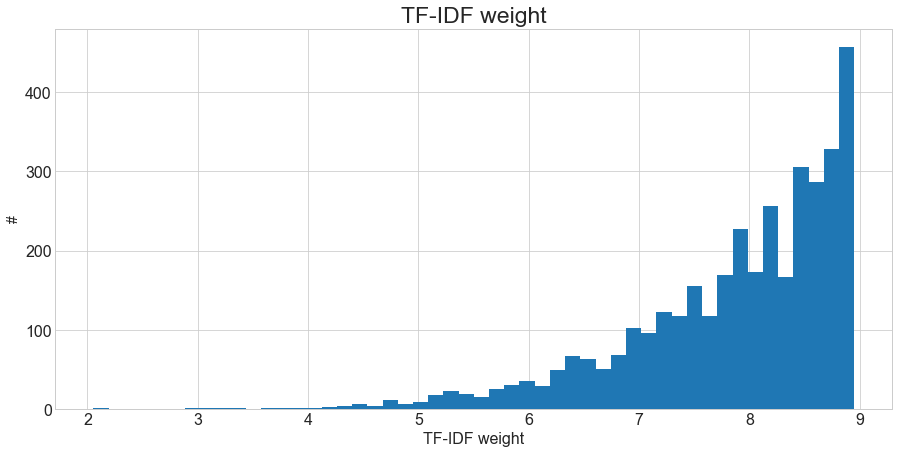

In [26]:
tfidf.tfidf.hist(bins=50, figsize=(15,7));
plt.xlabel('TF-IDF weight', fontsize=16); plt.ylabel('#', fontsize=14)
plt.xticks(fontsize=16); plt.yticks(fontsize=16);
plt.title('TF-IDF weight', fontsize=23);

In [27]:
tfidf.sort_values(by=['tfidf'], ascending=True).head(10)

,tfidf
'',2.053833
http,2.958025
great,3.129110
's,3.292231
https,3.397063
n't,3.607441
thanks,3.707410
--,3.800945
president,3.849551
obama,4.093383


In [28]:
# HERE WE SEE WHAT NEEDS TO BE  CLEANED!!! 
# '', http, 's https, n't, --

In [29]:
tfidf.sort_values(by=['tfidf'], ascending=False).head(10)

,tfidf
slot,8.951079
warrior,8.951079
editor,8.951079
miles,8.951079
broadcast,8.951079
upon,8.951079
bright,8.951079
kimguilfoyle,8.951079
silence,8.951079
brexit,8.951079


In [30]:
tfidf.iloc[-2:]

,tfidf
🇺🇸,7.981679
👍,8.353242
